In [62]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *

In [3]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [39]:
path = "/Users/marf/Desktop/PhD Temp/2017-12-05/"
file_name = "DS_inv_20171205.h5"

In [43]:
hdf5_file = pd.HDFStore(path+file_name)

In [227]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

In [228]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/df_raw_ratios',
 '/evaluation/no_bgd_corr/df_bgd_corr',
 '/evaluation/no_bgd_corr/df_raw_ratios',
 '/evaluation/no_bgd_corr/No_interference_corr/df_DS_inv_af_interf_corr',
 '/evaluation/no_bgd_corr/No_interference_corr/df_DS_inv_bf_interf_corr',
 '/evaluation/no_bgd_corr/No_interference_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/no_bgd_corr/Te125_Xe129_corr/df_DS_inv_af_interf_corr',
 '/evaluation/no_bgd_corr/Te125_Xe129_corr/df_DS_inv_bf_interf_corr',
 '/evaluation/no_bgd_corr/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/no_bgd_corr/Te126_Xe129_corr/df_DS_inv_af_interf_corr',
 '/evaluation/no_bgd_corr/Te126_Xe129_corr/df_DS_inv_bf_interf_corr',
 '/evaluation/no_bgd_corr/Te126

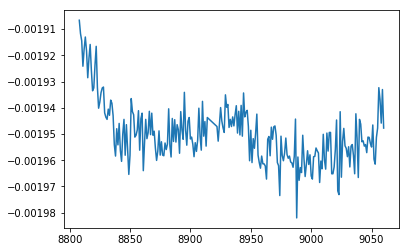

In [107]:
# Check Baselines
column = "129"

df_all = hdf5_file['/raw_data/baselines']
plt.plot(df_all["Filenumber"], df_all[column])
plt.show()

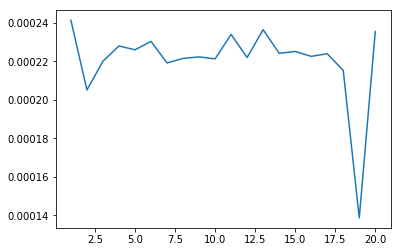

In [220]:
# Check Signals
column = "125"

df_all = hdf5_file['/raw_data/signals_zero']
df_all = df_all[df_all.index == "2017-12-06 17:36:00"]
plt.plot(df_all["Cycle"], df_all[column])
plt.show()

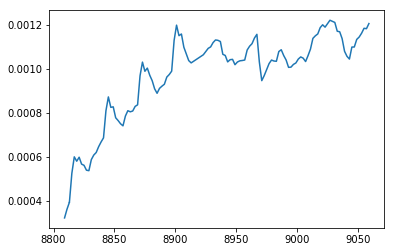

In [116]:
# Check Background which is substracted
column = "H1 (1)"

df_all = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
plt.plot(df_all["Filenumber"], df_all[column])
plt.show()

In [229]:
df_all = hdf5_file['/evaluation/bgd_outlier_corr/Te126_Xe129_corr/df_DS_inv_af_interf_corr']

df_outlier_rej = pd.DataFrame()
df_outlier = pd.DataFrame()

for value in df_all["Filenumber"].unique():
    df_outlier_rej = df_outlier_rej.append(mad_outlier_rejection(df_all[df_all["Filenumber"] == value]))
    df_outlier = df_outlier.append(mad_outlier(df_all[df_all["Filenumber"] == value]))

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


In [241]:
column = 'eSn_118_117'
df_outlier[df_outlier[column].notnull()]

,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,a_nat0,b_nat0,c_nat0,m0.0:x,...,eSn_118_117,eSn_122_117,eSn_124_117,eSn_122_118,eSn_124_118,fsam,fspike,Q,Cycle,Filenumber
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-05 19:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440271,...,-2.523258,-12.418404,-17.243451,-9.897643,-14.723908,NaN,NaN,NaN,11,8813
2017-12-05 19:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.130664,-10.487027,-14.562204,-8.358145,-12.434190,NaN,NaN,NaN,19,8813
2017-12-05 19:38:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.106553,-10.368403,-14.397516,-8.263591,-12.293553,NaN,NaN,NaN,19,8817
2017-12-05 21:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.737720,-8.553637,-11.877960,-6.817102,-10.142003,NaN,NaN,NaN,20,8831
2017-12-05 23:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.325526,-11.445694,-15.893104,-9.122289,-13.570734,NaN,NaN,NaN,7,8845
2017-12-05 23:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.183975,-10.749311,-14.926333,-8.567207,-12.745142,NaN,NaN,NaN,7,8847
2017-12-06 00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.524339,-12.423717,-17.250826,-9.901878,-14.730206,NaN,NaN,NaN,14,8851
2017-12-06 00:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440252,...,-2.548254,-12.541361,-17.414140,-9.995654,-14.869675,0.509027,0.490973,1.036771,14,8857
2017-12-06 01:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.342229,-6.607413,-9.175694,-5.265890,-7.834516,NaN,NaN,NaN,8,8859


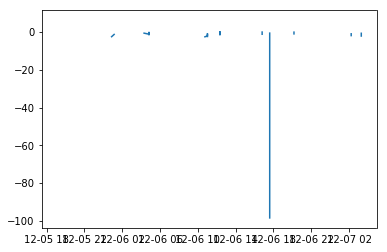

In [208]:
# Check sample measurements
column = "eSn_118_117"

plt.plot(df_outlier.index, df_outlier[column])
plt.show()

In [154]:
# Check sample measurements
column = "frac_ins_x2.5"

df_all = mad_outlier(hdf5_file['/evaluation/bgd_outlier_corr/Te126_Xe129_corr/df_DS_inv_af_interf_corr'])
df_all
#df_all = df_all.dropna(axis=1, how='all')
#plt.plot(df_all["Filenumber"], df_all[column])
#plt.show()

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,...,Nr2:z,frac_nat_x2,eSn_118_117,eSn_122_117,eSn_124_117,eSn_122_118,eSn_124_118,fsam,fspike,Q
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
hdf5_file['/evaluation/bgd_outlier_corr/Te126_Xe129_corr/df_DS_inv_af_interf_corr']

,Cycle,Filenumber,Sample,Num_of_Ana_Cyc,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,...,Nr2:z,frac_nat_x2,eSn_118_117,eSn_122_117,eSn_124_117,eSn_122_118,eSn_124_118,fsam,fspike,Q
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-05 18:34:00,1,8809,NIST + DS 0.5-0.5,1,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753772,-0.020984,-1.784801,-8.785304,-12.199609,-7.001753,-10.416667,0.508988,0.491012,1.036608
2017-12-05 18:34:00,2,8809,NIST + DS 0.5-0.5,1,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753927,-0.017435,-1.482997,-7.300172,-10.137590,-5.818037,-8.655876,0.509010,0.490990,1.036700
2017-12-05 18:34:00,3,8809,NIST + DS 0.5-0.5,1,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753866,-0.018825,-1.601145,-7.881581,-10.944856,-6.281442,-9.345208,0.508991,0.491009,1.036622
2017-12-05 18:34:00,4,8809,NIST + DS 0.5-0.5,1,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753988,-0.016052,-1.365366,-6.721276,-9.333794,-5.356641,-7.969517,0.508977,0.491023,1.036566
2017-12-05 18:34:00,5,8809,NIST + DS 0.5-0.5,1,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.754124,-0.012954,-1.101810,-5.424151,-7.532675,-4.322817,-6.431574,0.508966,0.491034,1.036520
2017-12-05 18:34:00,6,8809,NIST + DS 0.5-0.5,1,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753630,-0.024224,-2.060350,-10.141088,-14.081929,-8.082403,-12.024057,0.509004,0.490996,1.036676
2017-12-05 18:34:00,7,8809,NIST + DS 0.5-0.5,1,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753978,-0.016283,-1.384955,-6.817680,-9.467653,-5.433478,-8.083818,0.508976,0.491024,1.036560
2017-12-05 18:34:00,8,8809,NIST + DS 0.5-0.5,1,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753891,-0.018271,-1.554100,-7.650071,-10.623415,-6.096919,-9.070725,0.508984,0.491016,1.036594
2017-12-05 18:34:00,9,8809,NIST + DS 0.5-0.5,1,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753901,-0.018033,-1.533838,-7.550363,-10.484973,-6.017448,-8.952509,0.508986,0.491014,1.036602


In [ ]:
### calculate Standard-Sample Bracketing ###

# bracketing standard #
std_used = "NIST + DS 0.5-0.5"
# determine at which position the samples are which are bracketed
sub_index = df_DS_inv_mean[(df_DS_inv_mean["sample"].shift(1) == df_DS_inv_mean["sample"].shift(-1)) & (df_DS_inv_mean["sample"].shift(1) == std_used)].index
# remove measurements with values below 0.1V
corr_values = df_DS_inv_mean[df_DS_inv_mean["124"] >= 0.1]
# extract only standard data
corr_values_2 = corr_values[corr_values["sample"] == std_used]

# save sample names
sample = corr_values["sample"]
sample_2 = corr_values_2["sample"]

# remove sample names from dataframe for calculation
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

# calculate bracketing 
epsilon_NIST =  ((new - ((new.shift(1) + new.shift(-1))/2)))
epsilon_2 = ((new_2 - ((new_2.shift(1) + new_2.shift(-1))/2)))
# reinsert samples names
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample_2

# select samples by bracketing index
epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
#epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
# select only bracketed sample measurements in dataframe
epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"] != std_used]
# select only bracketed standard measurements in dataframe
epsilon_2 = epsilon_2[epsilon_2["sample"] == std_used]
# append bracketed sample and standard measurements
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
# sort dataframe by datetime
epsilon_comp = epsilon_comp.sort_index(axis=0)

In [ ]:
epsilon = epsilon_comp[["eSn_118_117", "eSn_122_117", "eSn_124_117", "eSn_122_118", "eSn_124_118", "Q", "fspike","sample"]]
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2, 'count']), decimals=3)

In [ ]:
### method to create plots to show bracketing data ###

# sel_ratio = "112/118"
std = "NIST + DS 0.5-0.5"



In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')